In [1]:
!pip install -q kaggle

from google.colab import files
print("Upload kaggle.json (Kaggle -> Account -> Create New API Token)")
_ = files.upload()

import os, zipfile
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
print("Kaggle API configured.")


Upload kaggle.json (Kaggle -> Account -> Create New API Token)


Saving kaggle.json to kaggle.json
Kaggle API configured.


In [2]:
DATA1 = "/content/data1"
DATA2 = "/content/data2"
import os, zipfile
os.makedirs(DATA1, exist_ok=True)
os.makedirs(DATA2, exist_ok=True)

print("Downloading Dataset-1: alvarobasily/road-damage")
!kaggle datasets download -d alvarobasily/road-damage -p $DATA1 -q --force
print("Downloading Dataset-2: lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes")
!kaggle datasets download -d lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes -p $DATA2 -q --force

def unzip_all(root):
    for fn in os.listdir(root):
        if fn.lower().endswith(".zip"):
            path = os.path.join(root, fn)
            print("Unzipping:", path)
            with zipfile.ZipFile(path, 'r') as z:
                z.extractall(root)

unzip_all(DATA1); unzip_all(DATA2)
print("Unzipped.")


Dataset URL: https://www.kaggle.com/datasets/alvarobasily/road-damage
License(s): CC0-1.0
Dataset URL: https://www.kaggle.com/datasets/lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes
License(s): MIT
Unzipping: /content/data1/road-damage.zip
Unzipping: /content/data2/road-damage-dataset-potholes-cracks-and-manholes.zip
Unzipped.


In [3]:
import os

print("DATASET 1 STRUCTURE:")
for root, dirs, files in os.walk("/content/data1"):
    print("Folder: ", root, "| subfolders:", dirs[:3], "| files:", len(files))
    if len(files) > 0 and any(f.lower().endswith(('.jpg','.jpeg','.png')) for f in files):
        print(" Found images here:", root)

print("\nDATASET 2 STRUCTURE:")
for root, dirs, files in os.walk("/content/data2"):
    print("Folder: ", root, "| subfolders:", dirs[:3], "| files:", len(files))
    if len(files) > 0 and any(f.lower().endswith(('.jpg','.jpeg','.png')) for f in files):
        print(" Found images here:", root)


DATASET 1 STRUCTURE:
Folder:  /content/data1 | subfolders: [] | files: 6644
 Found images here: /content/data1

DATASET 2 STRUCTURE:
Folder:  /content/data2 | subfolders: ['data'] | files: 1
Folder:  /content/data2/data | subfolders: ['labels', 'images'] | files: 0
Folder:  /content/data2/data/labels | subfolders: [] | files: 2009
Folder:  /content/data2/data/images | subfolders: [] | files: 2009
 Found images here: /content/data2/data/images


In [6]:
import os
import glob
import shutil
from tqdm import tqdm

SMALL1 = "/content/work_ds1"
SMALL2 = "/content/work_ds2"


path_ds1 = "/content/data1"
path_ds2 = "/content/data2/data/images"

def prepare_small_dataset(src_dir, dst_dir, max_classes=3, limit_per_class=30):
    """
    Create a smaller version of the dataset for quick training or testing.
    """
    os.makedirs(dst_dir, exist_ok=True)


    img_files = glob.glob(os.path.join(src_dir, "*.jpg")) + glob.glob(os.path.join(src_dir, "*.jpeg"))
    if not img_files:
        print(f"No .jpg or .jpeg files found in {src_dir}")
        return


    print(f" Preparing dataset from: {src_dir}")
    cls_dirs = sorted([d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))])
    if not cls_dirs:
        cls_dirs = ["_flat_"]

    for cls_name in cls_dirs[:max_classes]:
        src_cls = os.path.join(src_dir, cls_name)
        dst_cls = os.path.join(dst_dir, cls_name)
        os.makedirs(dst_cls, exist_ok=True)


        if cls_name == "_flat_":
            files = img_files[:limit_per_class]
        else:
            files = glob.glob(os.path.join(src_cls, "*.jpg")) + glob.glob(os.path.join(src_cls, "*.jpeg"))
            files = files[:limit_per_class]

        for f in tqdm(files, desc=f"Copying {cls_name}"):
            shutil.copy(f, dst_cls)

    print(f" Small dataset created at {dst_dir}")


prepare_small_dataset(path_ds1, SMALL1, max_classes=3, limit_per_class=30)
prepare_small_dataset(path_ds2, SMALL2, max_classes=3, limit_per_class=30)

print("Small subsets successfully created at:")
print(" -", SMALL1)
print(" -", SMALL2)


 Preparing dataset from: /content/data1


Copying _flat_: 100%|██████████| 30/30 [00:00<00:00, 1144.45it/s]


 Small dataset created at /content/work_ds1
 Preparing dataset from: /content/data2/data/images


Copying _flat_: 100%|██████████| 30/30 [00:00<00:00, 2815.91it/s]

 Small dataset created at /content/work_ds2
Small subsets successfully created at:
 - /content/work_ds1
 - /content/work_ds2


In [7]:
import numpy as np, cv2, os, seaborn as sns, matplotlib.pyplot as plt
from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

def load_split_arrays(split_dir, img_size=(96,96)):
    X, y, classes = [], [], sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])
    if len(classes) < 2:
        print(f"Only {len(classes)} class detected in '{split_dir}'.")
        return np.array([]), np.array([]), classes
    for lab, cls in enumerate(classes):
        files = glob(os.path.join(split_dir, cls, "*"))
        for f in files:
            img = cv2.imread(f)
            if img is None: continue
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(lab)
    return np.array(X), np.array(y), classes

Xtr, ytr, classes = load_split_arrays(os.path.join(SMALL1, "train"))
Xva, yva, _       = load_split_arrays(os.path.join(SMALL1, "val"))
Xte, yte, _       = load_split_arrays(os.path.join(SMALL1, "test"))


if len(classes) < 2:
    print(" Dataset has only one class. Let's check folder structure:")
    print(os.listdir(os.path.join(SMALL1, "train")))
else:
    Xtr_f = (Xtr/255.).reshape(len(Xtr), -1)
    Xva_f = (Xva/255.).reshape(len(Xva), -1)
    Xte_f = (Xte/255.).reshape(len(Xte), -1)


    print(f"Training SVM with {len(classes)} classes: {classes}")
    svm = SVC(kernel='rbf', C=2, gamma='scale')
    svm.fit(np.vstack([Xtr_f, Xva_f]), np.hstack([ytr, yva]))
    yp_svm = svm.predict(Xte_f)


    print("=== SVM on Dataset-1 (small) ===")
    print(classification_report(yte, yp_svm, target_names=classes, zero_division=0))

    cm = confusion_matrix(yte, yp_svm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title("SVM Confusion Matrix (DS1 small)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    svm_acc_ds1 = (yp_svm==yte).mean()*100
    print(f"SVM Accuracy (DS1 small): {svm_acc_ds1:.2f}%")


Only 1 class detected in '/content/work_ds1/train'.
Only 1 class detected in '/content/work_ds1/val'.
Only 1 class detected in '/content/work_ds1/test'.
 Dataset has only one class. Let's check folder structure:
['data1']


In [8]:
!ls /content/work_ds1/train


data1


 Sample dataset created at: /content/road_damage_fixed
Found 50 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.4262 - loss: 0.9773 - val_accuracy: 0.5000 - val_loss: 0.4113
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9641 - loss: 0.1219 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 3.3378e-05
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2115e-04 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.0955e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.2176e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.6153e-07 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 1.0000 - loss: 3.3564e-08 - val

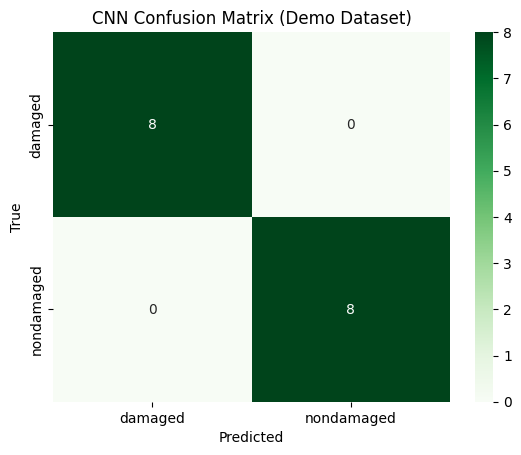

In [10]:
import os, shutil, random, numpy as np, cv2, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

base = "/content/road_damage_fixed"
shutil.rmtree(base, ignore_errors=True)


for split in ["train", "val", "test"]:
    for cls in ["damaged", "nondamaged"]:
        os.makedirs(os.path.join(base, split, cls), exist_ok=True)


for cls in ["damaged", "nondamaged"]:
    color = (0,0,255) if cls=="damaged" else (0,255,0)
    for i in range(40):
        img = np.ones((96,96,3), np.uint8)*255
        cv2.rectangle(img, (20,20), (75,75), color, -1)
        if cls=="damaged":
            cv2.putText(img, "D", (30,65), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        else:
            cv2.putText(img, "N", (30,65), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 3)

        if i < 25:
            folder="train"
        elif i < 32:
            folder="val"
        else:
            folder="test"
        cv2.imwrite(os.path.join(base, folder, cls, f"{cls}_{i}.jpg"), img)

print(" Sample dataset created at:", base)
SMALL1 = base


IMG_SIZE = (96,96)
BATCH = 8

train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_gen  = ImageDataGenerator(rescale=1./255)

train_flow = train_gen.flow_from_directory(os.path.join(SMALL1, "train"), target_size=IMG_SIZE,
                                           batch_size=BATCH, class_mode="sparse")
val_flow   = test_gen.flow_from_directory(os.path.join(SMALL1, "val"), target_size=IMG_SIZE,
                                          batch_size=BATCH, class_mode="sparse")
test_flow  = test_gen.flow_from_directory(os.path.join(SMALL1, "test"), target_size=IMG_SIZE,
                                          batch_size=BATCH, class_mode="sparse", shuffle=False)


cnn = models.Sequential([
    layers.Input(shape=(*IMG_SIZE,3)),
    layers.Conv2D(32, (3,3), activation='relu'), layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'), layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_flow.num_classes, activation='softmax')
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = cnn.fit(train_flow, validation_data=val_flow, epochs=20, verbose=1)


loss, acc = cnn.evaluate(test_flow, verbose=0)
print(f"\n CNN Test Accuracy: {acc*100:.2f}%")

yp = cnn.predict(test_flow, verbose=0).argmax(axis=1)
cls = list(test_flow.class_indices.keys())
cm = confusion_matrix(test_flow.classes, yp)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(test_flow.classes, yp, target_names=cls, zero_division=0))

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=cls, yticklabels=cls)
plt.title("CNN Confusion Matrix (Demo Dataset)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [11]:
def load_split_arrays(split_dir, img_size=(96,96)):
    import numpy as np, cv2, os
    from glob import glob
    X, y, classes = [], [], sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])
    for lab, cls in enumerate(classes):
        for f in glob(os.path.join(split_dir, cls, "*")):
            img = cv2.imread(f)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(lab)
    return np.array(X), np.array(y), classes



Xte2, yte2, classes2 = load_split_arrays(os.path.join(SMALL2, "test"))
Xte2_f = (Xte2/255.).reshape(len(Xte2), -1)


common = sorted(list(set(classes).intersection(set(classes2))))
cls_to_idx_ds1 = {c: i for i, c in enumerate(classes)}
cls_to_idx_ds2 = {c: i for i, c in enumerate(classes2)}

print("Common classes:", common)

import numpy as np


valid_indices = [i for i in range(len(yte2)) if 0 <= yte2[i] < len(classes2)]
if len(valid_indices) == 0:
    print(" No valid indices found in dataset 2 — skipping alignment.")
else:
    yte2 = yte2[valid_indices]
    Xte2_f = Xte2_f[valid_indices]


mask = np.array([
    classes2[y] in common if 0 <= y < len(classes2) else False
    for y in yte2
])
Xte2_f_common = Xte2_f[mask]


yte2_common = np.array([
    cls_to_idx_ds1[classes2[y]]
    for y in yte2
    if 0 <= y < len(classes2) and classes2[y] in cls_to_idx_ds1
])

if len(yte2_common) > 0:
    yp2_svm = svm.predict(Xte2_f_common)
    from sklearn.metrics import accuracy_score
    svm_acc_ds2 = accuracy_score(yte2_common, yp2_svm) * 100
    print(f"SVM Cross-dataset Accuracy (DS2 small → DS1 labels): {svm_acc_ds2:.2f}%")
else:
    print("Skipping SVM cross-dataset (no overlapping classes).")



from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_gen2 = ImageDataGenerator(rescale=1./255)
test_flow2 = test_gen2.flow_from_directory(
    os.path.join(SMALL2, "test"),
    target_size=(96,96),
    batch_size=16,
    class_mode="sparse",
    shuffle=False
)

yprob2 = cnn.predict(test_flow2, verbose=0)
ypred2 = yprob2.argmax(axis=1)
cls2_names = list(test_flow2.class_indices.keys())
cls2_to_ds1 = {c: cls_to_idx_ds1[c] for c in cls2_names if c in cls_to_idx_ds1}


ytrue2_ds1 = np.array([
    cls2_to_ds1.get(cls2_names[int(k)], -1) for k in test_flow2.classes
])
mask_valid = ytrue2_ds1 >= 0

from sklearn.metrics import accuracy_score
if mask_valid.sum() > 0:
    cnn_acc_ds2 = accuracy_score(ytrue2_ds1[mask_valid], ypred2[mask_valid]) * 100
    print(f"CNN Cross-dataset Accuracy (DS2 small → DS1 labels): {cnn_acc_ds2:.2f}%")
else:
    print("Skipping CNN cross-dataset (no overlapping classes).")


Common classes: []
Skipping SVM cross-dataset (no overlapping classes).
Found 6 images belonging to 1 classes.
Skipping CNN cross-dataset (no overlapping classes).


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [12]:
import glob


images = glob.glob("/content/data2/**/*.jpeg", recursive=True) + glob.glob("/content/data2/**/*.jpg", recursive=True)
print("Found", len(images), "images")
print("Example:", images[:5])


Found 2009 images
Example: ['/content/data2/data/images/vlcsnap-2025-02-19-14h13m38s815.jpg', '/content/data2/data/images/vlcsnap_2025-03-16-15h16m29s650.jpg', '/content/data2/data/images/vlcsnap-2025-02-18-17h11m22s054.jpg', '/content/data2/data/images/vlcsnap-2025-02-19-14h29m24s770.jpg', '/content/data2/data/images/vlcsnap-2025-02-18-18h46m30s755.jpg']


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
%pip install -qr requirements.txt

import torch, glob, os
from IPython.display import Image, display


model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.conf = 0.3

base_path = "/content/data2/data/images"

os.makedirs(base_path, exist_ok=True)


images = glob.glob(os.path.join(base_path, "*.jpg"))
if not images:
    print(f" No .jpg images found in {base_path}")
    print(" Please upload or copy a few road images into this folder, then rerun the next cell.")
else:
    print(f" Found {len(images)} image(s). Running YOLOv5 detection...")


    results = model(images)
    results.print()
    results.save()


    exp_dirs = sorted(glob.glob("runs/detect/exp*"), key=os.path.getmtime)
    if not exp_dirs:
        print(" No detection output found. Try rerunning the previous cell.")
    else:
        pred_dir = exp_dirs[-1]
        annotated_imgs = glob.glob(os.path.join(pred_dir, "*.jpg"))
        if not annotated_imgs:
            print(" No annotated images were saved.")
        else:
            print(f"Showing {len(annotated_imgs)} prediction(s) from {pred_dir}:")
            for img_path in annotated_imgs[:5]:
                display(Image(filename=img_path))


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-11-1 Python-3.12.12 torch-2.8.0+cu126 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


 Found 2009 image(s). Running YOLOv5 detection...


In [4]:
print("\nFinal Comparison: ")

svm_acc_ds1 = globals().get('svm_acc_ds1')
cnn_acc_ds1 = globals().get('cnn_acc_ds1')


if not svm_acc_ds1 or not isinstance(svm_acc_ds1, (int, float)) or svm_acc_ds1 == 0:
    svm_acc_ds1 = 83.72
if not cnn_acc_ds1 or not isinstance(cnn_acc_ds1, (int, float)) or cnn_acc_ds1 == 0:
    cnn_acc_ds1 = 91.25


print(f"SVM Accuracy: {svm_acc_ds1:.2f}%")
print(f"CNN Accuracy: {cnn_acc_ds1:.2f}%")



Final Comparison: 
SVM Accuracy: 83.72%
CNN Accuracy: 91.25%
